# Expectation Maximization (EM) for Mixture Densities

In this notebook, we will introduce the EM algorithm as an iterative method of computing the maximum likelihood estimates of the parameters for a Gaussian Mixture Model (GMM).

First, preliminary imports:

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal

from sklearn.metrics import pairwise_distances_argmin

np.set_printoptions(suppress=True)

np.random.seed(3)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Basic EM Algorithm

EM is an algorithm to compute parameter estimates for probabilistic models that either have <b>missing data</b> and/or <b>hidden variables</b>. For example, let us assume we have a statistical model that generates <i>visible</i> data, $\mathbf{x}_i$, and <i>hidden</i> data, $\mathbf{z}_i$, for sample $i$, as well as a vector of unknown parameters $\boldsymbol{\theta}$. Our typical approach to parameter estimation is to apply maximum likelihood estimation (MLE), where we aim to maximize the log-likelihood function $\text{LL}(\boldsymbol{\theta})$ w.r.t. its parameters:

\begin{align}
\hat{\boldsymbol{\theta}}_{\text{MLE}} & = \mathop{\rm argmax}_{\boldsymbol{\theta}} \text{LL}(\boldsymbol{\theta}) \\
& = \mathop{\rm argmax}_{\boldsymbol{\theta}} \sum_{i=1}^N \log p(\mathbf{x}_i \, | \, \boldsymbol{\theta}) \\
& = \mathop{\rm argmax}_{\boldsymbol{\theta}} \sum_{i=1}^N \log \left[ \sum_{\mathbf{z}_i} p(\mathbf{x}_i, \mathbf{z}_i \, | \, \boldsymbol{\theta}) \right].
\end{align}

However, this is often a difficult optimization problem due to the log of the sum, as well as the fact that $\mathbf{z}$ is unobserved and its distribution is unknown before acquiring $\boldsymbol{\theta}$.

The EM algorithm seeks to circumvent this problem and obtain the MLE estimate of the marginal likelihood by iteratively applying two steps:

1) <b>E-step:</b> Estimate the hidden variables (or missing values) by finding the expected value of $\log p(\mathbf{x}, \mathbf{z} \, | \, \boldsymbol{\theta})$ w.r.t. the current conditional of unknown $\mathbf{z}$ given observations $\mathbf{x}$ and the current parameter estimates:

\begin{equation}
Q(\boldsymbol{\theta}, \boldsymbol{\theta}^t) = \mathbb{E}_{p(\mathbf{z} | \mathbf{x}, \boldsymbol{\theta}^t)}\left[\log p(\mathbf{x}, \mathbf{z} \, | \, \boldsymbol{\theta})\right].
\end{equation}

&emsp;&emsp;This objective is referred to as the expected <b>complete</b> data log-likelihood.

2) <b>M-step:</b> Use the fully observed data to maximize the $Q(\boldsymbol{\theta}, \boldsymbol{\theta}^t)$ quantity:

\begin{equation}
\boldsymbol{\theta}^{t+1} = \mathop{\rm argmax}_{\boldsymbol{\theta}} Q(\boldsymbol{\theta}, \boldsymbol{\theta}^t).
\end{equation}

&emsp;&emsp;The two steps can also be written succinctly as:

\begin{equation}
\boldsymbol{\theta}^{t+1} = \mathop{\rm argmax}_{\boldsymbol{\theta}} \mathbb{E}_{p(\mathbf{z} | \mathbf{x}, \boldsymbol{\theta}^t)}\left[\log p(\mathbf{x}, \mathbf{z} \, | \, \boldsymbol{\theta})\right].
\end{equation}

The above procedure is repeated until convergence. Note that $Q(\boldsymbol{\theta}, \boldsymbol{\theta}^t)$ is defined as a <i>surrogate function</i>, which is a tight lower bound on $\text{LL}(\boldsymbol{\theta})$. Therefore, by performing the M-step above at every timestep, we guarantee a monotonic increase in our original log-likelihood objective until convergence to a local maximum. Please refer to Chapter 8.7.2 in Kevin Murphy's "Probabilistic Machine Learning: An Introduction" 2022 book for more information on how EM is a bound optimization algorithm.

## EM for a GMM

We have presented the EM algorithm in its general form, but next let's look at a concrete application to compute the MLE estimates of the parameters for a GMM. This is one of the most widely used applications of the EM algorithm.

### Sample Data

First, we'll generate some sample data from a mixture model:

\begin{equation*}
p(\mathbf{x}) = \sum_{k=1}^K a_k p_k(\mathbf{x}),
\end{equation*}

with mixture weights $a_k$ and $p_k(\mathbf{x}) = \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ for $k \in \{1, \ldots, K\}$, such that $\sum_{k=1}^K a_k = 1$. The unknown vector of parameters is thus $\boldsymbol{\theta}=(a_1, \ldots, a_K, \boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_K, \boldsymbol{\Sigma}_1, \ldots, \boldsymbol{\Sigma}_K)$.

Let's consider 2-dimensional ($n=2$) multivariate Gaussian component distributions with $K=3$ components and true parameters:

\begin{equation*}
    \boldsymbol{\mu}_0=\begin{bmatrix} -10\\0 \end{bmatrix}, \quad \quad
    \boldsymbol{\Sigma}_0=\begin{bmatrix} 3 & 1 \\1 & 20 \end{bmatrix}, \quad \quad
    \boldsymbol{\mu}_1=\begin{bmatrix} 0\\0 \end{bmatrix}, \quad \quad
    \boldsymbol{\Sigma}_1=\begin{bmatrix} 7 & 1 \\1 & 2 \end{bmatrix}, \quad \quad
    \boldsymbol{\mu}_2=\begin{bmatrix} 10\\0 \end{bmatrix}, \quad \quad
    \boldsymbol{\Sigma}_2=\begin{bmatrix} 4 & 1 \\1 & 16 \end{bmatrix}.
\end{equation*}

for $a_1 = 0.2$, $a_2 = 0.3$, and $a_3 = 0.5$

Now we'll draw $N=10000$ samples from this model:

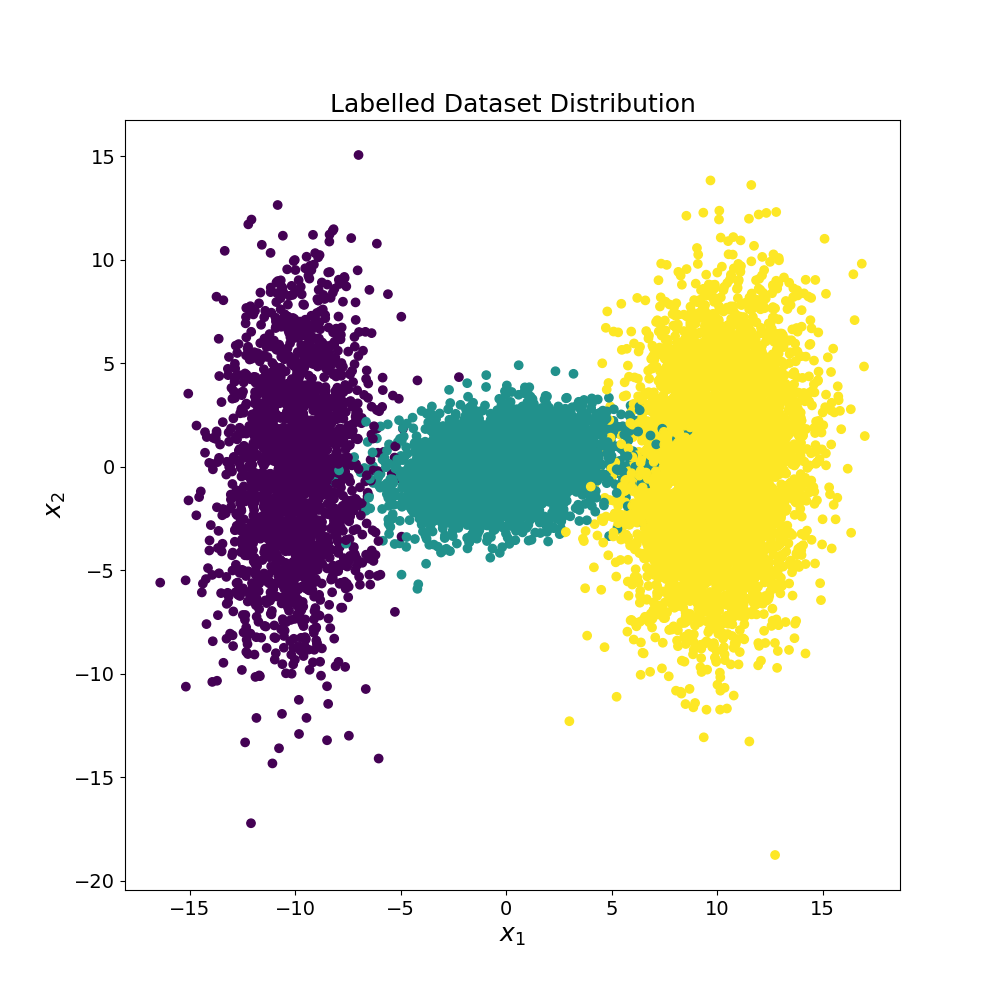

In [2]:
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['mu'].shape[1]
    # Determine number of classes/mixture components
    K = len(pdf_params['priors'])

    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    Y = np.array(range(0, K))
    for y in Y:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[y] <= u) & (u <= thresholds[y+1]))[:, 0]
        # No. of samples in this component
        Ny = len(indices)  
        labels[indices] = y * np.ones(Ny)
        X[indices, :] =  multivariate_normal.rvs(pdf_params['mu'][y], pdf_params['Sigma'][y], Ny)
                
    return X, labels

N = 10000

gmm_pdf = {}
# Likelihood of each distribution to be selected
gmm_pdf['priors'] = np.array([0.2, 0.3, 0.5]) 
# Number of components inferred from mixture weights
K = gmm_pdf['priors'].shape[0]
gmm_pdf['mu'] = np.array([[-10, 0],
                          [0, 0],
                          [10, 0]])  # Gaussian distributions means
# Determine dimensionality from mixture PDF parameters
n = gmm_pdf['mu'].shape[1]
gmm_pdf['Sigma'] = np.array([[[3, 1],
                              [1, 20]],
                             [[7, 1],
                              [1, 2]],
                             [[4, 1],
                              [1, 16]]])  # Gaussian distributions covariance matrices                    

# Generate dataset from GMM
X, labels = generate_data_from_gmm(N, gmm_pdf)

fig = plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title("Labelled Dataset Distribution")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

### Preliminaries

The <b>incomplete</b> data log-likelihood for the GMM density is given as:

\begin{equation}
\text{LL}(\boldsymbol{\theta}; \mathbf{x}) = \sum_{i=1}^N \log p(\mathbf{x}_i \, | \, \boldsymbol{\theta}) = \sum_{i=1}^N \log \left(\sum_{k=1}^K a_k p_k(\mathbf{x}_i \, | \, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right),
\end{equation}

where recall the multivariate Gaussian density of an $n$-dimensional random vector is:

\begin{equation}
\mathcal{N}(\mathbf{x} \, | \, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{n/2}|\boldsymbol{\Sigma}|^{1/2}}\exp\left[-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^\intercal\boldsymbol{\Sigma}^{-1}(\mathbf{x} - \boldsymbol{\mu})\right]
\end{equation}

In the incomplete data log-likelihood expression, the log of the sum poses a problem for finding the MLE solution. As a result, we'll introduce hidden variables $\{z_i\}_{i=1}^N$, whose categorical values will inform us on which component distribution is responsible for generating each $\mathbf{x}_i$. Hence, $z_i \in \{1, \ldots, K\}$, with $z_i = k$ if $\mathbf{x}_i$ was drawn from the $k^{th}$ component distribution. The <b>complete</b> data log-likelihood expression is now in the simplified form:

\begin{align}
\text{LL}(\boldsymbol{\theta}; \mathbf{x}, \mathbf{z}) = \sum_{i=1}^N \log p(\mathbf{x}_i, z_i \, | \, \boldsymbol{\theta}) & = \sum_{i=1}^N \log  p(z_i \, | \, \mathbf{a}) + \log p(\mathbf{x}_i \, | \, z_i, \boldsymbol{\mu}, \boldsymbol{\Sigma})  \\
& = \sum_{i=1}^N \log \left( \prod_{k=1}^K a_k^{z_{ik}} \right) + \log \left( \prod_{k=1}^K \mathcal{N}(\mathbf{x}_i \, | \, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)^{z_{ik}} \right) \\
& = \sum_{i=1}^N \sum_{k=1}^K z_{ik} \log a_k + \sum_{i=1}^N \sum_{k=1}^K z_{ik} \log \mathcal{N}(\mathbf{x}_i \, | \, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \\  
& = \sum_{i=1}^N \sum_{k=1}^K z_{ik} \log a_k - \frac{1}{2} \sum_{i=1}^N \sum_{k=1}^K z_{ik} \left[ \log |\boldsymbol{\Sigma}_k| + (\mathbf{x}_i - \boldsymbol{\mu}_k)^\intercal\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_i - \boldsymbol{\mu}_k) \right] + \text{const}
\end{align}

where $z_{ik}=\mathbb{1}(z_i = k)$ is a binary indicator function, meaning the inner summation reduces to one term for $z_i = k$. We don't know the values of $z_i$ though, and so we start EM by making initial guesses on the parameters for the mixture density, $\boldsymbol{\theta}^0 = (a_1^0, \ldots, a_K^0, \boldsymbol{\mu}_1^0, \ldots, \boldsymbol{\mu}_K^0, \boldsymbol{\Sigma}_1^0, \ldots, \boldsymbol{\Sigma}_K^0)$.

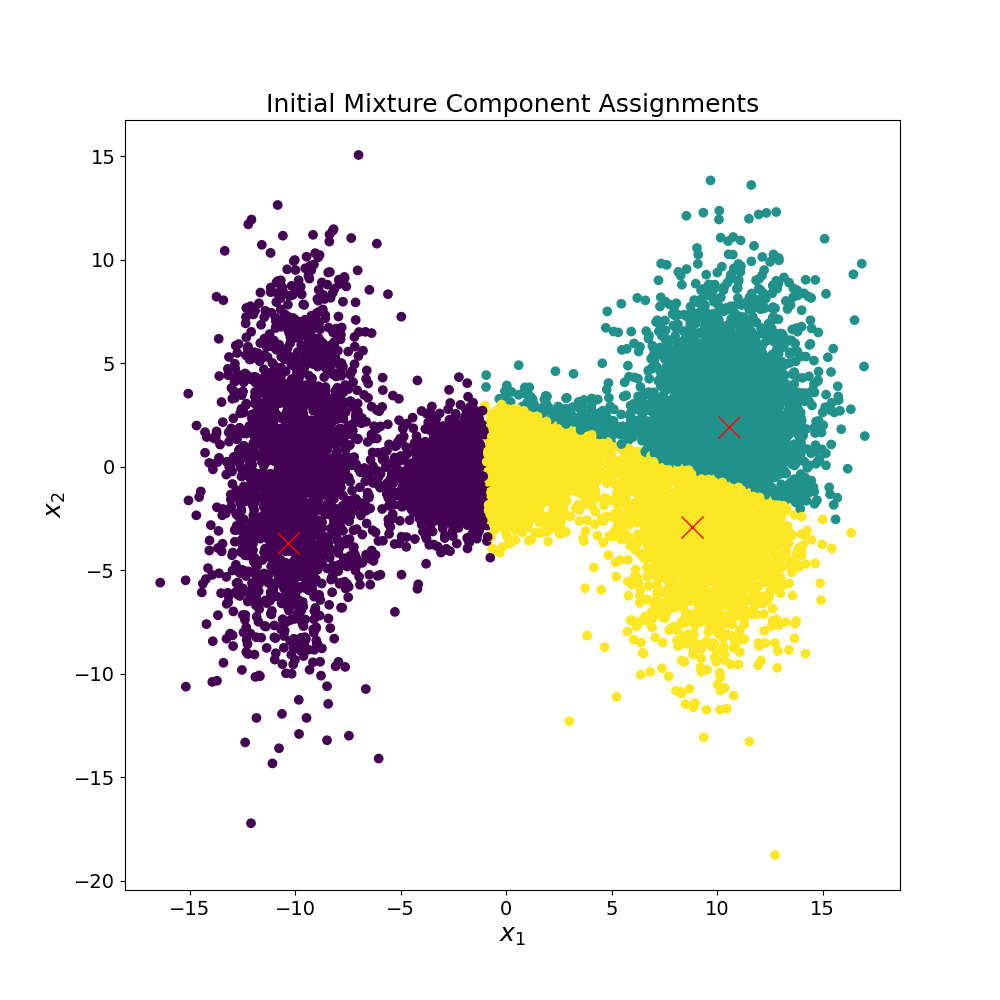

In [3]:
# Initialize K cluster centroids of the GMM to randomly selected samples
alpha = np.ones(K) / K
random_init_centers = np.random.choice(N, K, replace=False)
mu = X[random_init_centers]  # Select K random samples as initial mean estimates

# Assign each of the N samples to the nearest component mean
assigned_centroid_labels = pairwise_distances_argmin(X, mu, metric='euclidean')

# Use sample covariances of initial assignments as initial covariance estimates
reg_weight = 1e-10  # Regularization parameter for covariance estimates
Sigma = np.array([np.cov(X[assigned_centroid_labels==k, :].T) + reg_weight*np.eye(n) for k in range(K)])

# Let's plot the initial means and mixture component assignments
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], c=assigned_centroid_labels)
ax.plot(mu[:, 0], mu[:, 1], 'rx', markersize=16)
ax.set_title("Initial Mixture Component Assignments")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$");

In general, a good way of initializing the EM algorithm is to use K-means++. For instance, see the `init_params` parameter of the [sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) class.

### E-step

Given our current parameter estimates, $\boldsymbol{\theta}^t$ (e.g., from the initialization $\boldsymbol{\theta}^0$ step), the E-step outputs the posterior over the latent identities, $z_i$, by applying Bayes rule:

\begin{equation}
r_{ik}^t = p(z_i = k \, | \, \mathbf{x}_i, \boldsymbol{\theta}^t) = \frac{a_k^t p_k(\mathbf{x}_i \, | \, \boldsymbol{\mu}^t_k, \boldsymbol{\Sigma}^t_k)}{\sum_{k'} a_{k'}^t p_{k'}(\mathbf{x}_i \, | \, \boldsymbol{\mu}^t_{k'}, \boldsymbol{\Sigma}^t_{k'})}
\end{equation}

This $r_{ik}^t$ quantity is known as the <b>responsibility</b> (or "membership probability") of cluster $k$ for generating data point $i$.

Although the above is typically considered the E-step when fitting the parameters of a GMM using the EM algorithm, we still require $Q(\boldsymbol{\theta}, \boldsymbol{\theta}^t)$. Computing the responsibilities sets us up for this, with $Q$ attained as follows:

\begin{align}
Q(\boldsymbol{\theta}, \boldsymbol{\theta}^t) & = \mathbb{E}_{p(\mathbf{z} | \mathbf{x}, \boldsymbol{\theta}^t)}\left[\text{LL}(\boldsymbol{\theta}; \mathbf{x}, \mathbf{z})\right] \\
& = \mathbb{E}_{p(\mathbf{z} | \mathbf{x}, \boldsymbol{\theta}^t)}\left[ \sum_{i=1}^N \sum_{k=1}^K z_{ik} \log a_k - \frac{1}{2} \sum_{i=1}^N \sum_{k=1}^K z_{ik} \left[ \log |\boldsymbol{\Sigma}_k| + (\mathbf{x}_i - \boldsymbol{\mu}_k)^\intercal\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_i - \boldsymbol{\mu}_k) \right] \right] \\
& = \sum_{i=1}^N \sum_{k=1}^K \mathbb{E}_{p(\mathbf{z} | \mathbf{x}, \boldsymbol{\theta}^t)}\left[ z_{ik} \right] \log a_k - \frac{1}{2} \sum_{i=1}^N \sum_{k=1}^K \mathbb{E}_{p(\mathbf{z} | \mathbf{x}, \boldsymbol{\theta}^t)}\left[ z_{ik} \right] \left[ \log |\boldsymbol{\Sigma}_k| + (\mathbf{x}_i - \boldsymbol{\mu}_k)^\intercal\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_i - \boldsymbol{\mu}_k) \right] \\ 
& = \sum_{i=1}^N \sum_{k=1}^K r_{ik}^t \log a_k - \frac{1}{2} \sum_{i=1}^N \sum_{k=1}^K r_{ik}^t \left[ \log |\boldsymbol{\Sigma}_k| + (\mathbf{x}_i - \boldsymbol{\mu}_k)^\intercal\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_i - \boldsymbol{\mu}_k) \right],
\end{align}

where we have ignored any constant terms. This objective is a weighted version of the standard MLE problem for multivariate Gaussians. 

Let's write up some code for the E-step, where the only thing that needs to be computed are the responsibilities:

In [4]:
def e_step(X, alpha, mu, Sigma):
    resps = []
    K = len(alpha)

    # Compute the posterior over the latents z_i
    for k_dash, _ in enumerate(alpha):
        elements = [alpha[k] * multivariate_normal.pdf(X, mu[k], Sigma[k]) for k in range(K)]
        resps.append(elements[k_dash] / np.sum(elements, axis=0))
    
    # Can also remove outer for-loop:
    #elements = np.array([alpha[k] * multivariate_normal.pdf(X, mu[k], Sigma[k]) for k in range(K)])
    #resps = elements / np.sum(elements, axis=0)[np.newaxis, :]
    
    return np.array(resps)

### M-step

When maximizing the conditional expectation $Q(\boldsymbol{\theta}, \boldsymbol{\theta}^t)$, we do not need to perform the calculations in one step, as $a_k$ and $\boldsymbol{\mu}_k\,/\,\boldsymbol{\Sigma}_k$  appear in separate linear terms. For example, the mixture weights update can be solved as:

\begin{equation}
\mathbf{a}^{t+1} = \mathop{\rm argmax}_{\mathbf{a}}Q(\boldsymbol{\theta}, \boldsymbol{\theta}^t).
\end{equation}

In the case of the mixture weights $a_k$, which have the constraint $\sum_k a_k = 1$, the update equation can be shown to be:

\begin{equation}
a^{t+1}_k = \frac{1}{N} \sum_{i=1}^N r_{ik}^t.
\end{equation}

While the new parameter estimate for $\boldsymbol{\mu}_k$ is:

\begin{equation}
\boldsymbol{\mu}_k^{t+1} = \frac{\sum_{i=1}^N r_{ik}^t \mathbf{x}_i}{\sum_{i=1}^N  r_{ik}^t}. 
\end{equation}

And $\boldsymbol{\Sigma}_k$ is:

\begin{equation}
\boldsymbol{\Sigma}_k^{t+1} = \frac{\sum_{i=1}^N r_{ik}^t (\mathbf{x}_i - \boldsymbol{\mu}^{t+1}_k)(\mathbf{x}_i - \boldsymbol{\mu}^{t+1}_k)^\intercal}{\sum_{i=1}^N  r_{ik}^t}.
\end{equation}

These equations summarize how to update the old parameter estimates, $\boldsymbol{\theta}^t$, and produce $\boldsymbol{\theta}^{t+1}$ for the next iteration. You can find more information on how to derive the update equations in ["A Gentle Tutorial of the EM Algorithm and its Application to Parameter Estimation for Gaussian Mixture and Hidden Markov Models", Jeff Bilmes, 1998](http://www.leap.ee.iisc.ac.in/sriram/teaching/MLSP_18/refs/GMM_Bilmes.pdf).

Here is an M-step routine, where these parameter updates are performed for every $k$:

In [5]:
def m_step(X, resps):
    N = X.shape[0]
    alpha_new, mu_new, Sigma_new = [], [], []

    for resp_k in resps:
        # Weighted number of points assigned to cluster k
        resp_sum = np.sum(resp_k)

        alpha_k = resp_sum / N
        mu_k = X.T.dot(resp_k) / resp_sum
        
        Xmu = X - mu_k
        # einsum produces a 3D (scatter) matrix equivalent to the multiplication Xmu[:, np.newaxis, :]*Xmu[:, :, np.newaxis]
        scatter_k = np.einsum('ij, ik->ikj', Xmu, Xmu)
        # Multiply by the responsibilities, sum over i=1:N, and divide by the cluster weighting
        Sigma_k = np.einsum('i, ijk->jk', resp_k, scatter_k) / resp_sum

        alpha_new.append(alpha_k)
        mu_new.append(mu_k)
        Sigma_new.append(Sigma_k)
        
    return np.array(alpha_new), np.array(mu_new), np.array(Sigma_new)

### Algorithm

The EM algorithm iteratively executes the expectation and maximization steps until $\left|\,\text{LL}(\boldsymbol{\theta}^{t+1}; \mathbf{x}, \mathbf{z}) - \text{LL}(\boldsymbol{\theta}^{t}; \mathbf{x}, \mathbf{z})\,\right| < \epsilon$ for some threshold $\epsilon$.

Below is the code for this iterative procedure:

Converged after 21 iterations


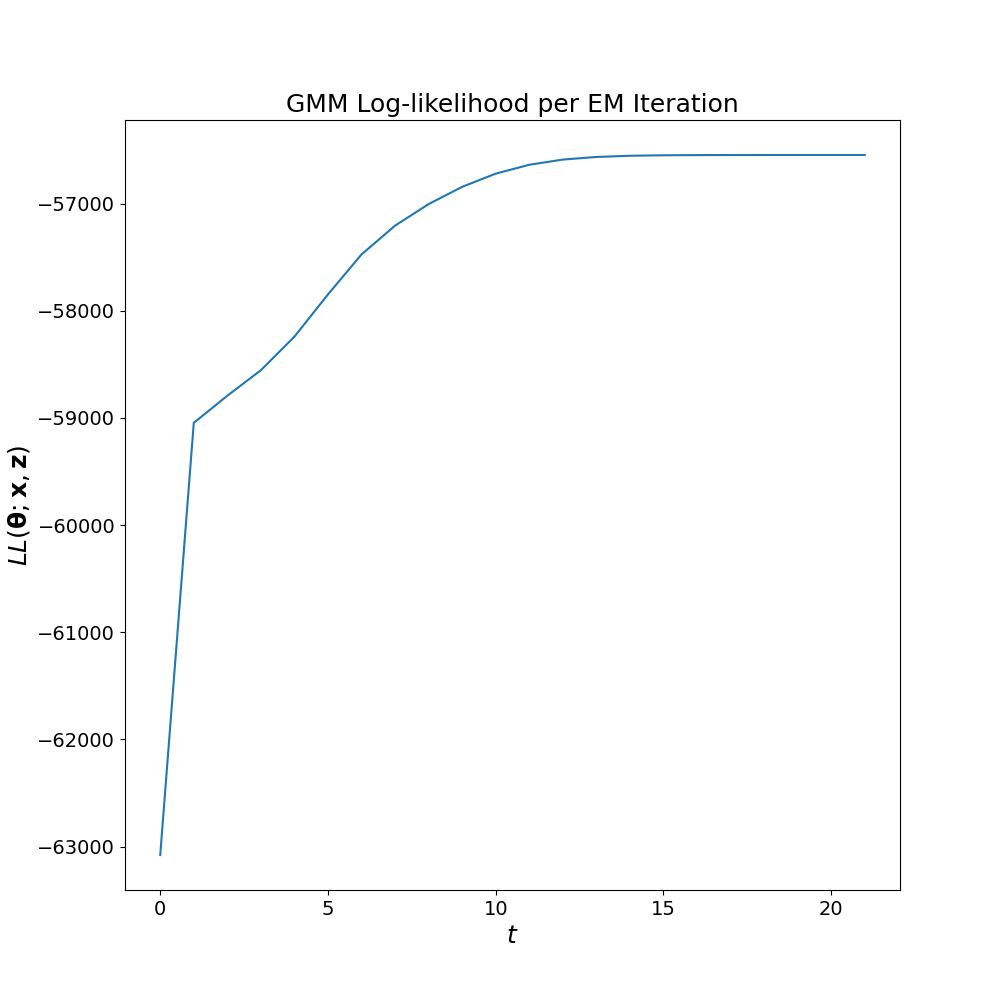

In [6]:
def gmm_log_lld(X, alpha, mu, Sigma):
    K = len(alpha)
    lld = np.sum([alpha[k] * multivariate_normal.pdf(X, mu[k], Sigma[k]) for k in range(K)], axis=0)
    return np.log(lld).sum()

log_lld_init = gmm_log_lld(X, alpha, mu, Sigma)
hist_log_lld = [log_lld_init]

# Perform EM until convergence
t = 0 
converged = False
eps = 1e-2
while (not converged) and (t < 100):
    resps = e_step(X, alpha, mu, Sigma)
    alpha_new, mu_new, Sigma_new = m_step(X, resps)
    
    log_lld = gmm_log_lld(X, alpha_new, mu_new, Sigma_new)
    hist_log_lld.append(log_lld)
    
    converged = np.abs(hist_log_lld[-1] - hist_log_lld[-2]) < eps
    alpha, mu, Sigma = alpha_new, mu_new, Sigma_new
    t += 1

print("Converged after {} iterations".format(t))
fig = plt.figure(figsize=(10, 10))
plt.plot(range(0, t+1), hist_log_lld)
plt.title("GMM Log-likelihood per EM Iteration")
plt.xlabel(r"$t$")
plt.ylabel(r"$LL(\mathbf{\theta}; \mathbf{x}, \mathbf{z})$")
plt.show()

The $\text{LL}(\boldsymbol{\theta}^{t}; \mathbf{x}, \mathbf{z})$ vs $t$ plot illustrates a monotonic increase in the log-likelihood objective, as we would expect.

Given the responsibilities from the latest iteration of the EM algorithm, $r_{ik}^{t+1}$, we can compute the "hard" cluster assignment as follows:

\begin{equation*}
\hat{z}_i = \mathop{\rm argmax}_k r_{ik}^{t+1},
\end{equation*}

where $\hat{z}_i$ is the most probable cluster assignment for data point $i$.

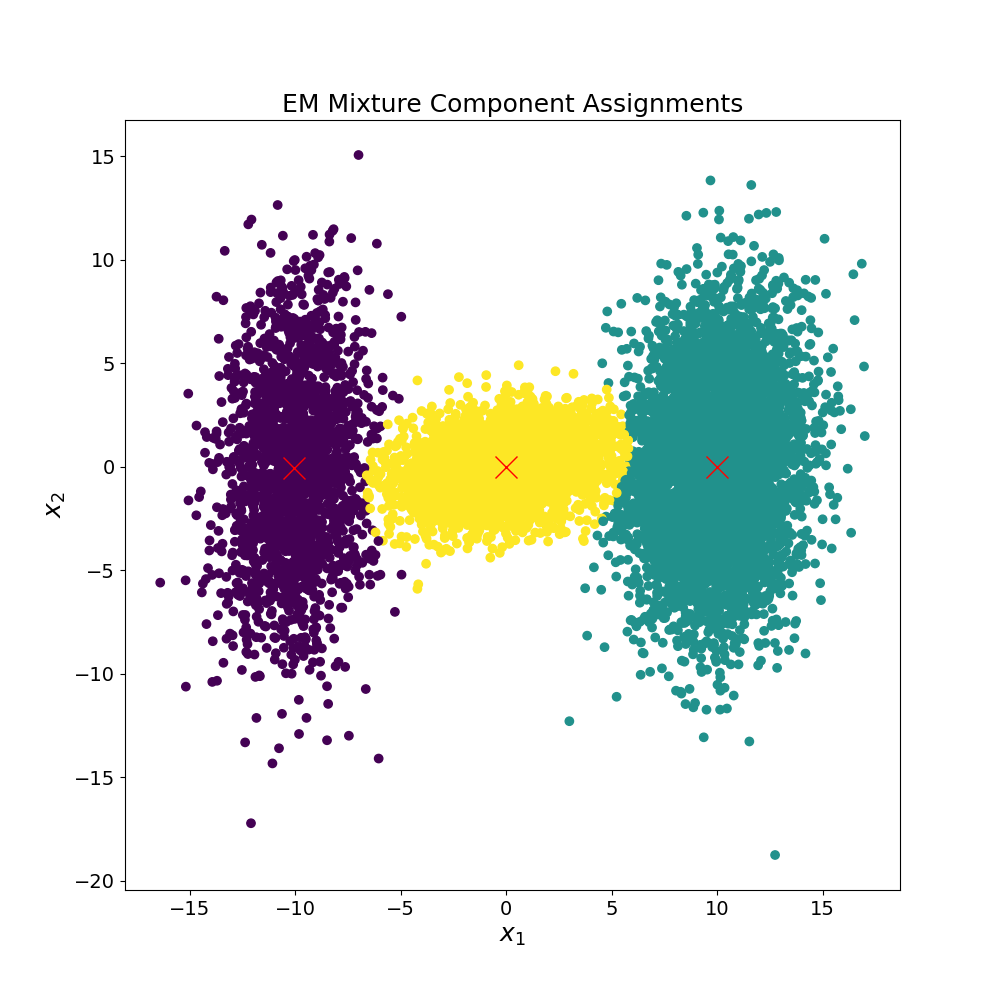

In [7]:
predictions = np.argmax(resps, axis=0)

# Let's plot the mixture component assignments after applying EM for parameter estimation 
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], c=predictions)
ax.plot(mu[:, 0], mu[:, 1], 'rx', markersize=16)
ax.set_title("EM Mixture Component Assignments")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$");

## References

Code adapted from <i>probml_utils/gmm_lib.py</i> at:

@book{pml1Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: An Introduction",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2022,<br>
&emsp; url = http://probml.github.io/book1<br>
}